In [1]:
!git clone https://github.com/Glen-Chue/Image-Classifier-with-VGG16-transfer-Learning.git

Cloning into 'Image-Classifier-with-VGG16-transfer-Learning'...
remote: Enumerating objects: 9895, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 9895 (delta 0), reused 7 (delta 0), pack-reused 9888
Receiving objects: 100% (9895/9895), 524.54 MiB | 35.30 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (9997/9997), done.


In [2]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Defining Relevant Preprocessing Steps**

In [3]:
#Transformers 
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

**Loading the Datasets**

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=transformer, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file,sep = ' ',header=None)
        self.transform = transform
        self.target_transform = target_transform
        self.n_classes = 20

    def __len__(self):
        return len(self.img_labels)


    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path).float()
        if image.shape[0] == 3:
            image = image[:3]
        elif image.shape[0] == 1:
            image = image.repeat(3, 1, 1)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
train = CustomImageDataset('/content/Image-Classifier-with-VGG16-transfer-Learning/train.txt',)

In [6]:
test = CustomImageDataset('/content/Image-Classifier-with-VGG16-transfer-Learning/test.txt',)

In [7]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=1, shuffle=True)

In [8]:
import torchvision
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


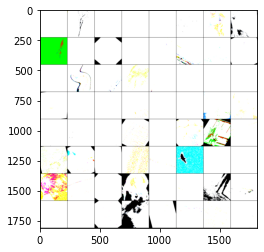

In [9]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


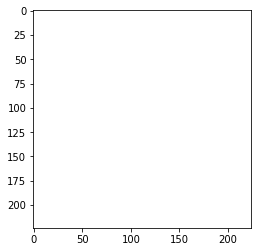

In [10]:
# Get a batch of training data
inputs, classes = next(iter(test_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

**Feature Extraction**

Defining Helper Functions

In [11]:
import torchvision.models as models
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [12]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [13]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
  model_ft = models.vgg16(pretrained=use_pretrained)
  set_parameter_requires_grad(model_ft, feature_extract)
  num_ftrs = model_ft.classifier[6].in_features
  model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
  input_size = 224
  return model_ft, input_size

Initializing Pre - Trained Model

In [14]:
feature_extract = True
model_ft, input_size = initialize_model(20, feature_extract, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [15]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
# Create training and validation dataloaders
dataloaders_dict = {'train':train_loader , 'val':test_loader}
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Send the model to GPU
model_ft = model_ft.to(device)

In [17]:
from torch import optim
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


Feature Extraction From Pre - Trained Model

In [18]:
import time,copy
# Setup the loss fxn1
criterion = nn.CrossEntropyLoss()
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=25, is_inception=False)

Epoch 0/24
----------
train Loss: 2.9876 Acc: 0.0802
val Loss: 2.9238 Acc: 0.0930

Epoch 1/24
----------
train Loss: 2.9463 Acc: 0.0955
val Loss: 2.8942 Acc: 0.1111

Epoch 2/24
----------
train Loss: 2.9140 Acc: 0.1081
val Loss: 2.8612 Acc: 0.1166

Epoch 3/24
----------
train Loss: 2.9050 Acc: 0.1081
val Loss: 2.8736 Acc: 0.1086

Epoch 4/24
----------
train Loss: 2.8998 Acc: 0.1101
val Loss: 2.8863 Acc: 0.1126

Epoch 5/24
----------
train Loss: 2.8954 Acc: 0.1142
val Loss: 2.8465 Acc: 0.1121

Epoch 6/24
----------
train Loss: 2.8930 Acc: 0.1116
val Loss: 2.8691 Acc: 0.1101

Epoch 7/24
----------
train Loss: 2.8916 Acc: 0.1130
val Loss: 2.8477 Acc: 0.1081

Epoch 8/24
----------
train Loss: 2.8942 Acc: 0.1140
val Loss: 2.8617 Acc: 0.1151

Epoch 9/24
----------
train Loss: 2.8877 Acc: 0.1165
val Loss: 2.8437 Acc: 0.1226

Epoch 10/24
----------
train Loss: 2.8912 Acc: 0.1170
val Loss: 2.8449 Acc: 0.1226

Epoch 11/24
----------
train Loss: 2.8825 Acc: 0.1187
val Loss: 2.8346 Acc: 0.1226

Ep

# Model Inference

In [20]:
! wget http://virtualization.com/wp-content/uploads/2008/03/virtualization-kvm-ubuntu.png

--2022-04-23 10:10:11--  http://virtualization.com/wp-content/uploads/2008/03/virtualization-kvm-ubuntu.png
Resolving virtualization.com (virtualization.com)... 72.47.224.111
Connecting to virtualization.com (virtualization.com)|72.47.224.111|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5857 (5.7K) [image/png]
Saving to: ‘virtualization-kvm-ubuntu.png’

virtualization-kvm- 100%[===================>]   5.72K  --.-KB/s    in 0s      

2022-04-23 10:10:12 (581 MB/s) - ‘virtualization-kvm-ubuntu.png’ saved [5857/5857]



In [46]:
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [55]:
from PIL import Image
img = Image.open("/content/virtualization-kvm-ubuntu.png").convert('RGB')
img = img.save("/content/final.jpg")
img = read_image("/content/final.jpg").float()
img_t = transformer(img)     
img_t = img_t.unsqueeze(0) 

In [60]:
img_t = img_t.cuda()
infer = model_ft(img_t)

In [62]:
infer.topk(5)

torch.return_types.topk(values=tensor([[0.7088, 0.6482, 0.2154, 0.1710, 0.1709]], device='cuda:0',
       grad_fn=<TopkBackward0>), indices=tensor([[16,  6, 11,  2, 19]], device='cuda:0'))